### Preprocessing for Automobile dataset.
+ Data source: https://www.kaggle.com/toramky/eda-for-automobile-dataset/data
+ Tutorial EDA kernel: https://www.kaggle.com/toramky/eda-for-automobile-dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
print('pandas version: ', pd.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from ipywidgets import interact

data_root = '~/Dataset/kaggle'
data_name = 'Automobile_data'

pandas version:  0.23.4


In [2]:
df = pd.read_csv('{}/{}.csv'.format(data_root, data_name))
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [3]:
# list of column names and type
df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

We need to correct the name of the columns, by replacing the `-` with `_` because the column name with `-` is not recognizable by the categorical-transformation encoder.

In [4]:
new_columns = [name.replace('-', '_') for name in df.columns]
df.columns = new_columns

In [5]:
df.describe()

,symboling,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,city_mpg,highway_mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


### 1. Step by step cleaning the dataset

#### 1.1. Null fields
+ Use `df.isnull()` to check each 'cell' in the table is null or not.
Then summary the number of null values for each feature.
+ No `null` found :D

In [6]:
df.isnull().sum()

symboling            0
normalized_losses    0
make                 0
fuel_type            0
aspiration           0
num_of_doors         0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_of_cylinders     0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

#### 1.2. Missing value
+ Count the number of '?' symbol in each column. Then try to manually clean each feature.

In [7]:
df.isin(['?']).sum(axis=0)

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
num_of_doors          2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_of_cylinders      0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

So we found that, the following fields containing '?':
+ normalized-losses    41
+ num-of-doors          2
+ bore                  4
+ stroke                4
+ horsepower            2
+ peak-rpm              2
+ price                 4

Note that we have `num-of-doors` categorical field with values in $\{two, four\}$, that we cannot replace by `mean` value. For the categorical field, replace the missing value by the most frequent value.

In [8]:
# for the numeric field, replace the missing value by mean of other rows and cast type of target field.
def replace_by_mean_with_numeric_type(field_name, field_type):
    field = df[field_name].loc[df[field_name] != '?']
    mean = field.astype(str).astype(field_type).mean()
    df[field_name] = df[field_name].replace('?', mean).astype(field_type)

In [9]:
# for the categorical field, replace by the most frequent value.
def replace_with_most_frequent(field_name):
    most_frequent = df[field_name].value_counts().index[0]
    df[field_name].replace('?', most_frequent, inplace=True)

In [10]:
def replace_missing_values(field_name, field_type):
    print('replacing: ', field_name, field_type)
    if field_type in [int, float]:
        replace_by_mean_with_numeric_type(field_name, field_type)
    else:
        replace_with_most_frequent(field_name)

In [11]:
error_fields = [
    ('normalized_losses', int),
    ('num_of_doors', str), # it will not be replaced :D
    ('bore', float),
    ('stroke', float),
    ('horsepower', int),
    ('peak_rpm', int),
    ('price', int),
]

In [12]:
for field_name, field_type in error_fields:
    replace_missing_values(field_name, field_type)

replacing:  normalized_losses <class 'int'>
replacing:  num_of_doors <class 'str'>
replacing:  bore <class 'float'>
replacing:  stroke <class 'float'>
replacing:  horsepower <class 'int'>
replacing:  peak_rpm <class 'int'>
replacing:  price <class 'int'>


In [13]:
df.describe()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.253659,5125.365854,25.219512,30.751220,13207.126829
std,1.245307,31.681008,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.519219,476.979095,6.542142,6.886443,7868.768212
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,101.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,122.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10595.000000
75%,2.000000,137.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### 1.3. Outlier
+ The Tut of EDA in kaggle kernel shows that, the `horsepower` contains outliers. So let's remove all rows in which the value of `horsepower` is out of 99.7% of confident (3 times standard dev).

In [14]:
df.horsepower = df.horsepower.astype(int)
hp_mean = df.horsepower.mean()
hp_std = df.horsepower.std()
print(hp_mean, hp_std)
df = df[np.abs(df.horsepower - hp_mean) <= (3 * hp_std)]
print(df.shape) # two row removed

104.25365853658536 39.51921906205877
(203, 26)


### 2. Transform the data
+ We have some categorical fields, which we want to convert to numerical.
Make sure to get a list of categorical fields.
According to the data description, we can use these fields as `target` field.
+ A quick search leds us to a detailed tutorial of categorical data transformation (with exactly this dataset): http://pbpython.com/categorical-encoding.html. In this tut, many strategies are proposed:
    * manual find and replace, e.g. 'four' -> 4, 'two' -> 2
    * label encoding: 'four' -> 0, 'two' -> 1
    * one hot encoding using `get_dummies`: generate new columns for each discrete values
    * custom binary encoding (complicated)
    * sklearn LabelEncoder, LabelBinarizer
    * advanced sklearn-contrib: Backward Difference encoding or polynomial encoding
+ TODO: try different techniques and evaluate based on the final viz result.

In [15]:
numeric_fields = df._get_numeric_data().columns
print(numeric_fields)

categorical_fields = list(set(df.columns) - set(numeric_fields))
print(categorical_fields)

Index(['symboling', 'normalized_losses', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_size', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')
['drive_wheels', 'make', 'num_of_doors', 'body_style', 'fuel_type', 'aspiration', 'num_of_cylinders', 'engine_type', 'engine_location', 'fuel_system']


Show some graphs of the distribution of the categorical fields

n_plots=10, n_rows=4, n_cols=3


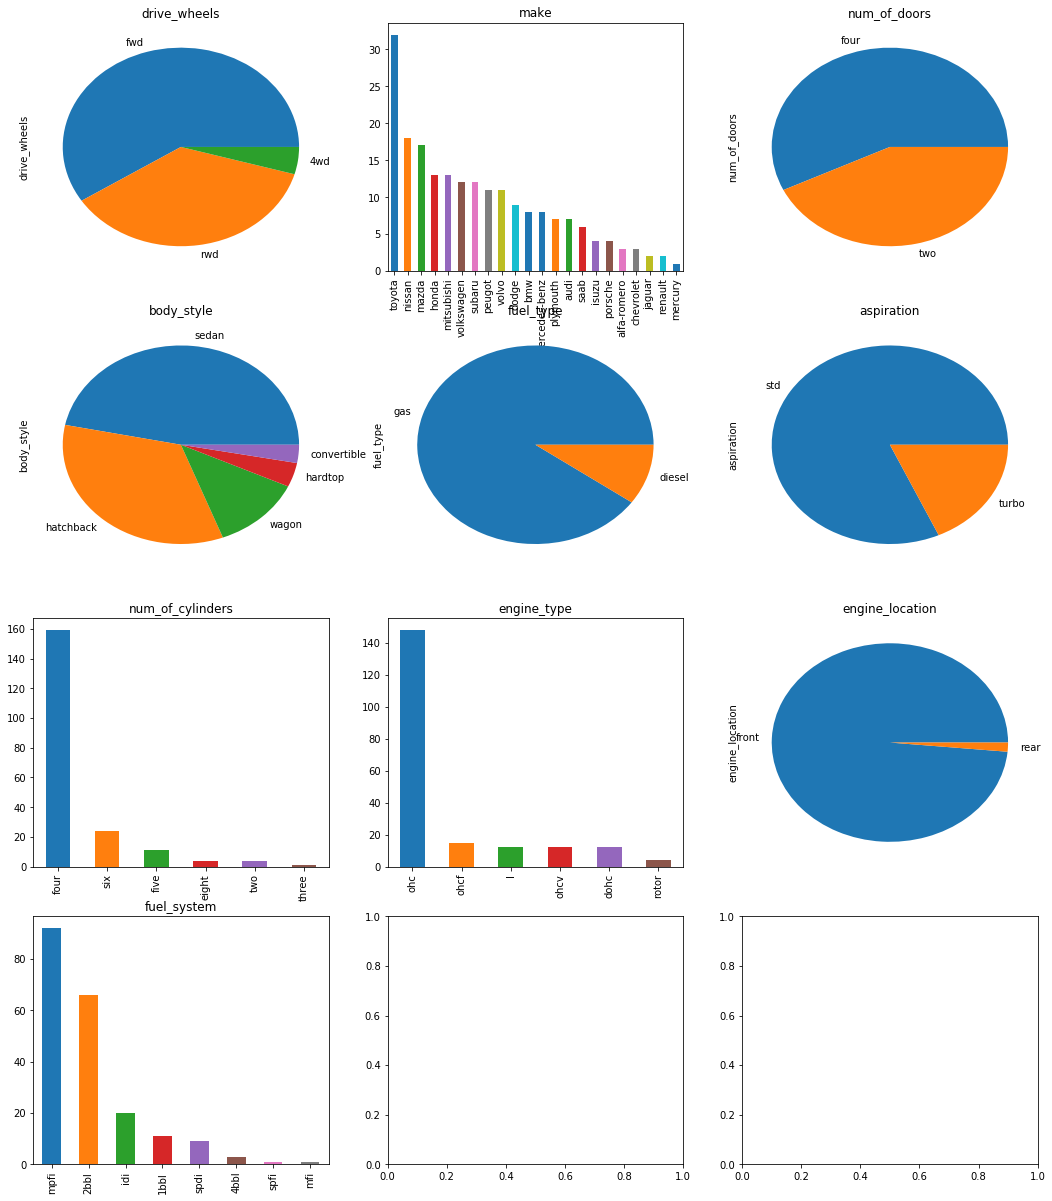

In [16]:
n_plots = len(categorical_fields)
n_cols = 3
n_rows = n_plots // n_cols if n_plots % n_cols == 0 else n_plots // n_cols + 1
print('n_plots={}, n_rows={}, n_cols={}'.format(n_plots, n_rows, n_cols))
_, axes = plt.subplots(n_rows, n_cols, figsize=(18, 21))
axes = axes.ravel()

for i, categorical_field in enumerate(categorical_fields):
    field_counts = df[categorical_field].value_counts()
    kind = 'bar' if field_counts.shape[0] > 5 else 'pie'
    field_counts.plot(kind=kind, title=categorical_field, ax=axes[i])

plt.show()    

Let's do transformation for the categorical field. Renote the tut: http://pbpython.com/categorical-encoding.html
+ Test sklearn-contrib package BackwardDifferenceEncoder

In [17]:
! pip install category_encoders

In [18]:
import category_encoders as ce

# Get a new clean dataframe
obj_df = df.select_dtypes(include=['object']).copy()

# Specify the columns to encode then fit and transform
encoder = ce.backward_difference.BackwardDifferenceEncoder(obj_df, cols=None)
encoder.fit(obj_df, verbose=1)

# Only display the first 8 columns for brevity
transformed_df = encoder.transform(obj_df)

In [19]:
data = np.concatenate(
    [df.select_dtypes(exclude=['object']).values, transformed_df.values],
    axis=1)

col_names = df.select_dtypes(exclude=['object']).columns.tolist() + transformed_df.columns.tolist()
print(data.shape)
print(col_names)

(203, 74)
['symboling', 'normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price', 'col_make_0', 'col_make_1', 'col_make_2', 'col_make_3', 'col_make_4', 'col_make_5', 'col_make_6', 'col_make_7', 'col_make_8', 'col_make_9', 'col_make_10', 'col_make_11', 'col_make_12', 'col_make_13', 'col_make_14', 'col_make_15', 'col_make_16', 'col_make_17', 'col_make_18', 'col_make_19', 'col_make_20', 'col_make_21', 'col_fuel_type_0', 'col_fuel_type_1', 'col_aspiration_0', 'col_aspiration_1', 'col_num_of_doors_0', 'col_num_of_doors_1', 'col_body_style_0', 'col_body_style_1', 'col_body_style_2', 'col_body_style_3', 'col_body_style_4', 'col_drive_wheels_0', 'col_drive_wheels_1', 'col_drive_wheels_2', 'col_engine_location_0', 'col_engine_location_1', 'col_engine_type_0', 'col_engine_type_1', 'col_engine_type_2', 'col_engine_type_3', 'col_engine_type_4', 'col_engine_type_5

#### Save the pre-processed dataset with multi-aspects labels

In [72]:
print(type(data))
print(type(multiaspect_labels['make'].tolist()))

dataset = {
    'data': data,
    'multi_aspects':{
        aspect_name: {
            'targets': multiaspect_labels[aspect_name].tolist(),
            'target_names': np.unique(multiaspect_labels[aspect_name])
        } for aspect_name in multiaspect_labels.columns
    }
}

import pickle
out_name = './data/Automobile_transformed.pkl'
with open(out_name, 'wb') as out_file:
    pickle.dump(dataset, out_file)
    
with open(out_name, 'rb') as in_file:    
    test_pkl = pickle.load(in_file)
    test_X = test_pkl['data']
    test_y = np.array(test_pkl['multi_aspects']['make']['targets'])
    print(test_X.shape, test_y.shape)

<class 'numpy.ndarray'>
<class 'list'>
(203, 74) (203,)


### 3. PCA
+ Do PCA on the transformed data
+ Use categorical field as multi-aspect labels.

In [20]:
# a list of categorical field used as label
multiaspect_labels = obj_df.astype('category')
multiaspect_labels.describe()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,engine_type,num_of_cylinders,fuel_system
count,203,203,203,203,203,203,203,203,203,203
unique,22,2,2,2,5,3,2,6,6,8
top,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,32,183,166,116,95,120,200,148,159,92


#### Interactive scatter plot with multi-aspect labels selection

In [40]:
@interact(labels=multiaspect_labels.columns, methods=['auto', 'full', 'arpack', 'randomized'], std=[True, False])
def pca_with_labels(labels, methods, std):
    print('Color by ', labels)
    pca = PCA(n_components=2)
    X = data
    if std:
        X = StandardScaler().fit_transform(X)
    X2d = pca.fit_transform(X)
    
    print(pca.explained_variance_ratio_)
    
    plt.scatter(X2d[:,0], X2d[:,1], c=multiaspect_labels[labels].cat.codes, cmap='tab10')
    plt.matshow(pca.components_)
    plt.colorbar()
    plt.show()

interactive(children=(Dropdown(description='labels', options=('make', 'fuel_type', 'aspiration', 'num_of_doors…

### 4. Which type of category-transformation encoding work best?

In [41]:
def do_pca(pca, X, encoding_name):
    X2d = pca.fit_transform(X)
    result = (
        encoding_name,
        pca.explained_variance_ratio_.sum(),
        *pca.explained_variance_ratio_,
        X2d
    )
    print('PCA explained_variance_ratio_', pca.explained_variance_ratio_)
    plt.scatter(X2d[:, 0], X2d[:, 1],
                c=multiaspect_labels.make.cat.codes, cmap='tab10')
    pca_results.append(result)
    plt.show()

In [42]:
def label_encoding(obj_df):
    cat_df = obj_df.astype('category')
    cat_df = cat_df.apply(lambda x: x.cat.codes)
    return cat_df

In [43]:
def label_encoding_sklearn(obj_df):
    lb_encoder = LabelEncoder()
    obj_df = obj_df.apply(lambda col: lb_encoder.fit_transform(col))
    return obj_df

In [44]:
def dummies_encoding(obj_df):
    return pd.get_dummies(obj_df)

In [45]:
def backward_encoding(obj_df):
    encoder = ce.backward_difference.BackwardDifferenceEncoder(obj_df, cols=None)
    encoder.fit(obj_df, verbose=1)
    return encoder.transform(obj_df)

In [46]:
transformations1 = {
    'categorical_encoding': label_encoding,
    'label_encoding_sklearn': label_encoding_sklearn,
    'dummies_encoding': dummies_encoding,
    'backward_encoding': backward_encoding,
}

advanced_encoders = [
    ce.BinaryEncoder,
    ce.HashingEncoder,
    ce.HelmertEncoder,
    ce.OneHotEncoder,
    ce.OrdinalEncoder,
    ce.SumEncoder,
    ce.PolynomialEncoder,
    ce.BaseNEncoder,
    ce.BackwardDifferenceEncoder,
    # ce.LeaveOneOutEncoder,
    # ce.TargetEncoder,
]

transformations2 = {
    str(encoder): lambda x: encoder(cols=None).fit(x).transform(x)
    for encoder in advanced_encoders
}

transformations = {**transformations2, **transformations1}

Transform with <class 'category_encoders.binary.BinaryEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


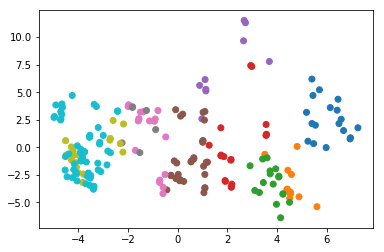

Transform with <class 'category_encoders.hashing.HashingEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


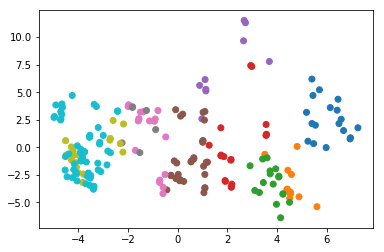

Transform with <class 'category_encoders.helmert.HelmertEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


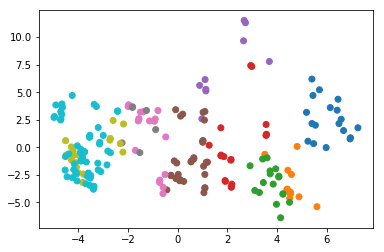

Transform with <class 'category_encoders.one_hot.OneHotEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


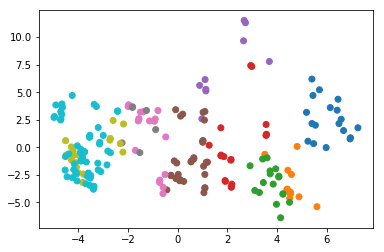

Transform with <class 'category_encoders.ordinal.OrdinalEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


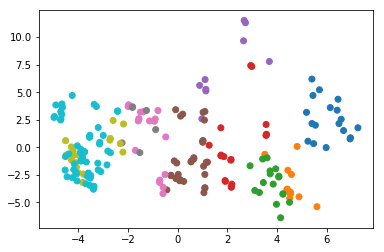

Transform with <class 'category_encoders.sum_coding.SumEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


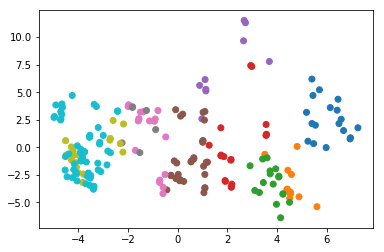

Transform with <class 'category_encoders.polynomial.PolynomialEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


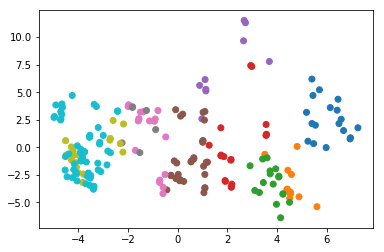

Transform with <class 'category_encoders.basen.BaseNEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


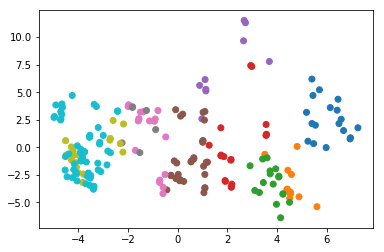

Transform with <class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


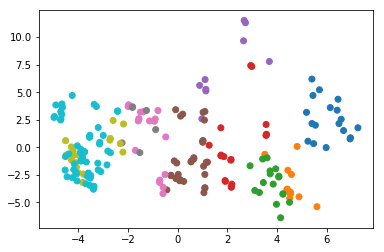

Transform with categorical_encoding, data shape (203, 26)
PCA explained_variance_ratio_ [0.32779152 0.17140764]


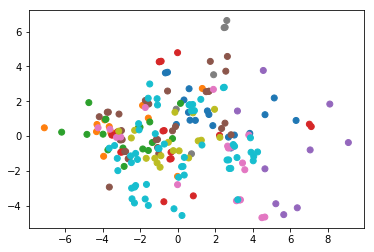

Transform with label_encoding_sklearn, data shape (203, 26)
PCA explained_variance_ratio_ [0.32779152 0.17140764]


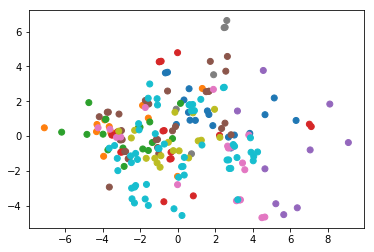

Transform with dummies_encoding, data shape (203, 74)
PCA explained_variance_ratio_ [0.15956893 0.09650943]


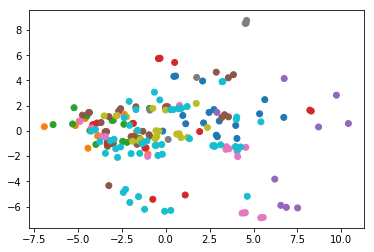

Transform with backward_encoding, data shape (203, 74)
PCA explained_variance_ratio_ [0.18884976 0.15719373]


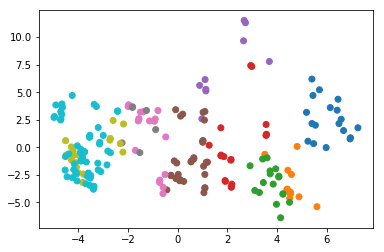

In [48]:
pca = PCA(n_components=2)
std_scaler = StandardScaler()
pca_results = []

for encoding_name, encoding_func in transformations.items():
    cat_df = encoding_func(obj_df.copy())
    data = np.concatenate(
        [df.select_dtypes(exclude=['object']).values, cat_df.values],
        axis=1
    )
    print('Transform with {}, data shape {}'.format(encoding_name, data.shape))
    
    data = std_scaler.fit_transform(data)
    do_pca(pca, X=data, encoding_name=encoding_name)